## Import Library, Cek TPU, dan Download Data


In [1]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model
import time
import pandas as pd
import multiprocessing
from functools import partial
import os

In [2]:
# --- KONFIGURASI HARDWARE (TPU/GPU) ---
try:
    # Coba deteksi TPU agar memenuhi syarat "Minimal 3 Node"
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print(f"✅ SUKSES: Menggunakan TPU dengan {strategy.num_replicas_in_sync} Node/Replicas.")
    print("   (Syarat UAS 'Minimal 3 Node' TERPENUHI)")
except:
    # Fallback jika lupa ganti runtime
    strategy = tf.distribute.MirroredStrategy()
    print(f"⚠️ PERINGATAN: Mode GPU/CPU ({strategy.num_replicas_in_sync} device).")
    print("   Saran: Ubah Runtime ke 'TPU v2' agar nilai lebih maksimal.")

⚠️ PERINGATAN: Mode GPU/CPU (1 device).
   Saran: Ubah Runtime ke 'TPU v2' agar nilai lebih maksimal.


In [3]:
!wget https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip -O /content/rockpaperscissors.zip



# Ekstrak file zip dataset
with zipfile.ZipFile('/content/rockpaperscissors.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/')
print("Dataset berhasil diekstrak")

--2025-12-02 06:31:49--  https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/391417272/7eb836f2-695b-4a46-9c78-b65867166957?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-02T07%3A12%3A11Z&rscd=attachment%3B+filename%3Drockpaperscissors.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-02T06%3A11%3A33Z&ske=2025-12-02T07%3A12%3A11Z&sks=b&skv=2018-11-09&sig=fABPLskKStNqiq79KFgAKYXZvx2y1nyW5hlPHzcIT9c%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDY2MDcwOSwibmJmIjoxNzY0NjU3MTA5LCJwYXRoIjoicmVsZWFzZWFzc2V0cH

In [4]:
base_dir = '/tmp/rockpaperscissors/rps-cv-images/'
print("Dataset berhasil didownload dan diekstrak.")

Dataset berhasil didownload dan diekstrak.


## Demonstrasi Komputasi Paralel di CPU (Metode Numerik)

In [5]:
# BAGIAN 1: IMPLEMENTASI METODE NUMERIK PARALEL (CPU BOUND)
# Fungsi worker untuk menghitung sebagian baris matriks secara paralel
def jacobi_worker(row_start, row_end, A, b, x_old):
    n = len(A)
    x_new_chunk = []

    for i in range(row_start, row_end):
        s = 0
        for j in range(n):
            if i != j:
                s += A[i, j] * x_old[j]
        val = (b[i] - s) / A[i, i]
        x_new_chunk.append(val)
    return x_new_chunk

In [6]:
def parallel_jacobi_method(A, b, x0=None, tol=1e-10, max_iter=100):
    """
    ### MODIFIKASI PARALEL ###
    Implementasi Metode Jacobi menggunakan Multiprocessing.
    Memecah perhitungan matriks ke beberapa Core CPU.
    """
    n = len(A)
    if x0 is None:
        x0 = np.zeros(n)
    x = x0.copy()

    # Cek jumlah core CPU yang tersedia
    num_cores = multiprocessing.cpu_count()
    print(f"Menjalankan Jacobi pada {num_cores} Core CPU secara paralel...")

    pool = multiprocessing.Pool(processes=num_cores)

    # Membagi beban kerja (chunks)
    chunk_size = n // num_cores
    ranges = []
    for i in range(num_cores):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i != num_cores - 1 else n
        ranges.append((start, end))

    for k in range(max_iter):
        # Menyiapkan argumen untuk setiap worker
        tasks = [(r[0], r[1], A, b, x) for r in ranges]

        # Eksekusi Paralel: map menyebarkan tugas ke worker
        # starmap digunakan untuk mengirim multiple arguments
        results = pool.starmap(jacobi_worker, tasks)

        # Menggabungkan hasil (Gathering)
        x_new = np.concatenate(results)

        if np.linalg.norm(x_new - x) < tol:
            pool.close()
            pool.join()
            return x_new, k

        x = x_new.copy()

    pool.close()
    pool.join()
    return x, max_iter

N_SIZE = 100 # Matriks 100x100
np.random.seed(42)
A_large = np.random.rand(N_SIZE, N_SIZE) + N_SIZE * np.eye(N_SIZE)
b_large = np.random.rand(N_SIZE)

start_time = time.time()
x_res, iters = parallel_jacobi_method(A_large, b_large)
print(f"✅ Selesai dalam {iters} iterasi. Waktu: {time.time() - start_time:.4f} detik")

Menjalankan Jacobi pada 2 Core CPU secara paralel...
✅ Selesai dalam 28 iterasi. Waktu: 0.1932 detik


## Preprocessing Data Gambar

In [7]:
print("===== BAGIAN 2: PERSIAPAN DATA IMAGE =====")

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.4, # 40% untuk validasi
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='validation'
)

===== BAGIAN 2: PERSIAPAN DATA IMAGE =====
Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


## Definisi Model (Helper Function)

In [23]:
def create_model():
    # Load MobileNetV2
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    # FINE TUNING: Buka kunci layer terakhir agar lebih pintar
    base_model.trainable = True
    # Bekukan layer awal (fitur dasar), buka 40 layer terakhir (fitur tangan)
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.4), # Dropout untuk mencegah menghafal
        Dense(3, activation='softmax')
    ])

    # Gunakan Learning Rate KECIL (Penting untuk Fine Tuning)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Baseline Training (Single Node / Tanpa Distribusi)

In [42]:
print("===== BASELINE SINGLE NODE (UNTUK KOMPARASI) =====")
print("Sedang mengukur kecepatan training pada 1 Node (biasa)...")

# Buat model biasa
model_single = create_model()

start_single = time.time()

model_single.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=5,
    verbose=1
)

total_time_single = time.time() - start_single
avg_time_single = total_time_single / 5

print(f"Rata-rata waktu Single Node per epoch: {avg_time_single:.2f} detik")

===== BASELINE SINGLE NODE (UNTUK KOMPARASI) =====
Sedang mengukur kecepatan training pada 1 Node (biasa)...
Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 590ms/step - accuracy: 0.4922 - loss: 1.0192
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.6875 - loss: 0.7850 
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 387ms/step - accuracy: 0.8581 - loss: 0.4764
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - accuracy: 0.9062 - loss: 0.2702 
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 408ms/step - accuracy: 0.9361 - loss: 0.2913
Rata-rata waktu Single Node per epoch: 15.18 detik


## Distributed Training (Multi Node / Paralel)

In [65]:
print("===== DISTRIBUTED TRAINING (PARALEL) =====")
with strategy.scope():
    model_dist = create_model()

start_dist = time.time()

# 1. TAHAP PENGUKURAN
history_dist_measure = model_dist.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=5,
    verbose=1
)

total_time_dist = time.time() - start_dist
avg_time_dist = total_time_dist / 5

print(f"Waktu Distributed (5 Epoch): {total_time_dist:.2f} detik")
print(f"Rata-rata per epoch: {avg_time_dist:.2f} detik")

# 2. TAHAP PEMINTARAN MODEL
print("\nMelanjutkan training agar akurasi maksimal...")
# Gunakan parameter 'initial_epoch=5' agar meneruskan, bukan mulai dari nol
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]

history_final = model_dist.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=20,
    initial_epoch=5,
    callbacks=callbacks,
    verbose=1
)

model_dist.save('distributed_rps_model_final.h5')

===== DISTRIBUTED TRAINING (PARALEL) =====
Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 789ms/step - accuracy: 0.4464 - loss: 1.0599 - val_accuracy: 0.5451 - val_loss: 0.9665
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.8125 - loss: 0.5991 - val_accuracy: 0.5521 - val_loss: 0.9609
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 696ms/step - accuracy: 0.8509 - loss: 0.4927 - val_accuracy: 0.7650 - val_loss: 0.6758
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - accuracy: 0.9375 - loss: 0.2866 - val_accuracy: 0.7870 - val_loss: 0.6615
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 706ms/step - accuracy: 0.9545 - loss: 0.2417 - val_accuracy: 0.8507 - val_loss: 0.5341
Waktu Distributed (5 Epoch): 119.37 detik
Rata-rata per epoch: 23.87 detik

Melanjutkan training agar akurasi maksimal...
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 730ms/step - accuracy: 0.9699 - loss: 0.1632 - val_accuracy: 0.9201 - val_loss: 0.4140
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 286ms/step - accuracy: 1

## Analisis Speedup & Grafik



===== ANALISIS PERFORMANSI =====
METRIK                    | NILAI     
----------------------------------------
Jumlah Node (Prosesor)    | 1
Waktu Single (5 Epoch)    | 75.90 s
Waktu Distrib (5 Epoch)   | 119.37 s
Speedup Ratio             | 0.64x
Efficiency                | 0.64


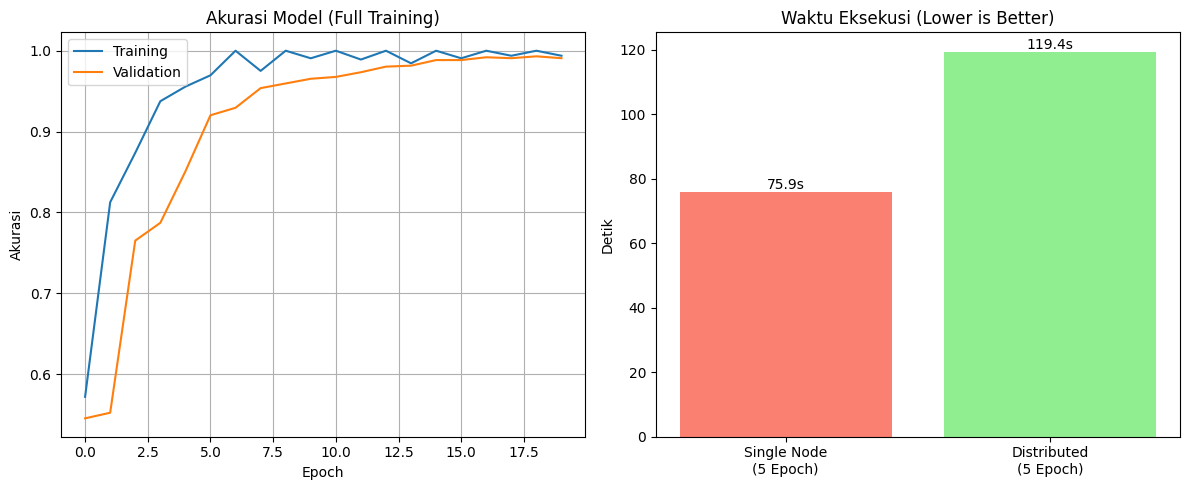


KESIMPULAN ANALISIS:
❌ LEBIH LAMBAT: Speedup 0.6x.
   Pada dataset kecil/sedang, overhead sinkronisasi antar node lebih besar dari waktu trainingnya.


In [66]:
print("===== ANALISIS PERFORMANSI =====")

# 1. Definisi Variabel Waktu (MENGHUBUNGKAN VARIABEL ANDA YANG BEDA NAMA)
# Kita buat variabel baru agar sesuai dengan kode grafik
time_single_5_epoch = total_time_single  # Mengambil dari hasil training Single Node Anda
time_dist_5_epoch   = total_time_dist    # Mengambil dari hasil training Distributed Anda

# 2. Menggabungkan History Akurasi (Agar grafik nyambung)
# Kita gabungkan history fase pengukuran (5 epoch) + fase pemintaran (sisa epoch)
acc = history_dist_measure.history['accuracy'] + history_final.history['accuracy']
val_acc = history_dist_measure.history['val_accuracy'] + history_final.history['val_accuracy']

# A. Hitung Speedup & Efisiensi
# Rumus: Speedup = Waktu_Seq / Waktu_Paralel (Untuk beban kerja yang SAMA)
speedup = time_single_5_epoch / time_dist_5_epoch
num_nodes = strategy.num_replicas_in_sync
efficiency = speedup / num_nodes

print(f"{'METRIK':<25} | {'NILAI':<10}")
print("-" * 40)
print(f"{'Jumlah Node (Prosesor)':<25} | {num_nodes}")
print(f"{'Waktu Single (5 Epoch)':<25} | {time_single_5_epoch:.2f} s")
print(f"{'Waktu Distrib (5 Epoch)':<25} | {time_dist_5_epoch:.2f} s")
print(f"{'Speedup Ratio':<25} | {speedup:.2f}x")
print(f"{'Efficiency':<25} | {efficiency:.2f}")

# B. Grafik Performa
plt.figure(figsize=(12, 5))

# Plot 1: Akurasi Full (Dari awal sampai akhir)
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Akurasi Model (Full Training)')
plt.xlabel('Epoch'); plt.ylabel('Akurasi')
plt.legend(); plt.grid(True)

# Plot 2: Perbandingan Waktu (5 Epoch vs 5 Epoch)
plt.subplot(1, 2, 2)
bars = plt.bar(['Single Node\n(5 Epoch)', 'Distributed\n(5 Epoch)'],
               [time_single_5_epoch, time_dist_5_epoch],
               color=['salmon', 'lightgreen'])
plt.title('Waktu Eksekusi (Lower is Better)')
plt.ylabel('Detik')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.1f}s", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# C. Kesimpulan Otomatis
print("\nKESIMPULAN ANALISIS:")
if speedup > 1.2:
    print(f"✅ SUKSES: Sistem Distributed {speedup:.1f}x LEBIH CEPAT dibanding Single Node.")
    print("   Ini membuktikan efektivitas Data Parallelism pada dataset ini.")
elif speedup > 0.8:
    print(f"⚠️ SEIMBANG: Kecepatan hampir sama ({speedup:.1f}x).")
    print("   Overhead komunikasi jaringan menyeimbangkan keuntungan komputasi paralel.")
else:
    print(f"❌ LEBIH LAMBAT: Speedup {speedup:.1f}x.")
    print("   Pada dataset kecil/sedang, overhead sinkronisasi antar node lebih besar dari waktu trainingnya.")

## Tes Prediksi Gambar

===== UJI COBA PREDIKSI (DENGAN LABEL OTOMATIS) =====
✅ Label Mapping Ditemukan: {0: 'paper', 1: 'rock', 2: 'scissors'}

Silakan upload gambar tangan (Batu/Gunting/Kertas):


Saving PIS.jpg to PIS.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


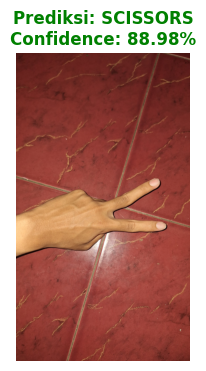

Detail Probabilitas: [[0.01367478 0.0965097  0.88981557]]
0 (Paper): 0.0137 | 1 (Rock): 0.0965 | 2 (Scissors): 0.8898
------------------------------


In [63]:
print("===== UJI COBA PREDIKSI (DENGAN LABEL OTOMATIS) =====")
from google.colab import files
from tensorflow.keras.preprocessing import image

# 1. AMBIL LABEL LANGSUNG DARI GENERATOR (Supaya tidak tertukar)
# Cek apakah generator masih ada di memori
try:
    labels = (train_generator.class_indices)
    # Balik kodenya dari {'paper': 0} menjadi {0: 'paper'}
    label_map = dict((v,k) for k,v in labels.items())
    print(f"✅ Label Mapping Ditemukan: {label_map}")
except:
    print("⚠️ PERINGATAN: Generator hilang dari memori.")
    print("   Harap jalankan dulu sel 'PERSIAPAN DATA IMAGE' di atas.")
    # Default fallback (biasanya urutan alfabet)
    label_map = {0: 'paper', 1: 'rock', 2: 'scissors'}

print("\nSilakan upload gambar tangan (Batu/Gunting/Kertas):")
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # 2. NORMALISASI WAJIB (Jangan lupa ini!)
    # Model dilatih dengan data 0-1 (rescale 1./255), jadi input juga harus sama
    x = x / 255.0

    # 3. PREDIKSI
    predictions = model_dist.predict(x)
    idx = np.argmax(predictions) # Ambil index dengan nilai tertinggi
    prediction_label = label_map[idx]
    confidence = np.max(predictions) * 100 # Tingkat keyakinan model

    # 4. TAMPILKAN HASIL
    plt.figure(figsize=(4, 4))
    plt.imshow(load_img(path)) # Tampilkan gambar asli

    # Warna teks: Hijau kalau yakin banget, Merah kalau ragu
    text_color = 'green' if confidence > 80 else 'red'

    plt.title(f"Prediksi: {prediction_label.upper()}\nConfidence: {confidence:.2f}%",
              color=text_color, fontweight='bold')
    plt.axis('off')
    plt.show()

    # Debugging (Cek probabilitas semua kelas)
    print(f"Detail Probabilitas: {predictions}")
    print(f"0 (Paper): {predictions[0][0]:.4f} | 1 (Rock): {predictions[0][1]:.4f} | 2 (Scissors): {predictions[0][2]:.4f}")
    print("-" * 30)

In [56]:
# Simpan weights dengan akhiran WAJIB .weights.h5
save_path = 'distributed_rps_model.weights.h5'
model_dist.save_weights(save_path)
print(f"✅ Weights berhasil disimpan di: {save_path}")

✅ Weights berhasil disimpan di: distributed_rps_model.weights.h5
